# About This Notebook

This notebook is designed to facilitate the use of pychip locally without using the App. 
<br>
After setting up your kernel and importing required packages this notebook will guide you through the following steps:
1. Designate filepaths and names for your inputs and outputs
1. Indicate how many rows/columns the image should be splintered into
1. Initialize the classifier and create chips
1. Design your support set
1. Run the few shot classifier
1. Interpret results

## Optional: Set up virtual environment



### Here are steps to ensure that your virtual environment is set up as a kernel for running this notebook:
1. Install and activate conda
2. Run the following commands to create and activate an environment: 
    - conda create -n myenv
    - conda activate myenv
4. Navigate to the same folder with the requirements.txt file and run the following commands to set up the environment: 
    - conda install pip
    - pip3 install -r requirements.txt
5. Run the following commands to set up a kernel that can be used in jupyter notebook:
    - pip install --user ipykernel
    - python -m ipykernel install --user --name=myenv
6. Now you should see 'myenv' as an option in the dropdown list of available Kernels when jupyter notebook is running

## Import Required Packages

Note: This is designed to be run from within the few-shot-electron-microscopy directory. If your jupyter notebook is running from elsewhere, you may need to adjust some of these import statements.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import shutil
from few_shot.pychip_classifier import PychipClassifier
from IPython.display import Image, display, Markdown
%matplotlib inline

## Step 1: Designate filepaths and names for inputs and outputs

you may use exact or relative locations for these paths

In [2]:
# data_path is the base directory you will be working out of:
data_path = "Testing/multimodal1"

# img_name is the filename of the image you want to analyze (within the data_path folder)
img_name = "img1.jpg"

# spectrum_name is the filename of the list of spectra you want to associate with each pixel of the image
spectrum_name = "spectrum1.npy"

# results_path is the folder your results will save to
results_path = "Testing/multimodal1/results/"

# chips_path is the folder your chips will save to (if you choose to save them)
chips_path = "./Testing/multimodal1/results/chips"

## Step 2: Indicate how many rows/columns the image should be splintered into

You will be able to preview the size of chip created, and re run this section as many times as you'd like before creating the actual chips

In [3]:
# n_columns is the number of columns your image will be chipped in to
n_columns = 33

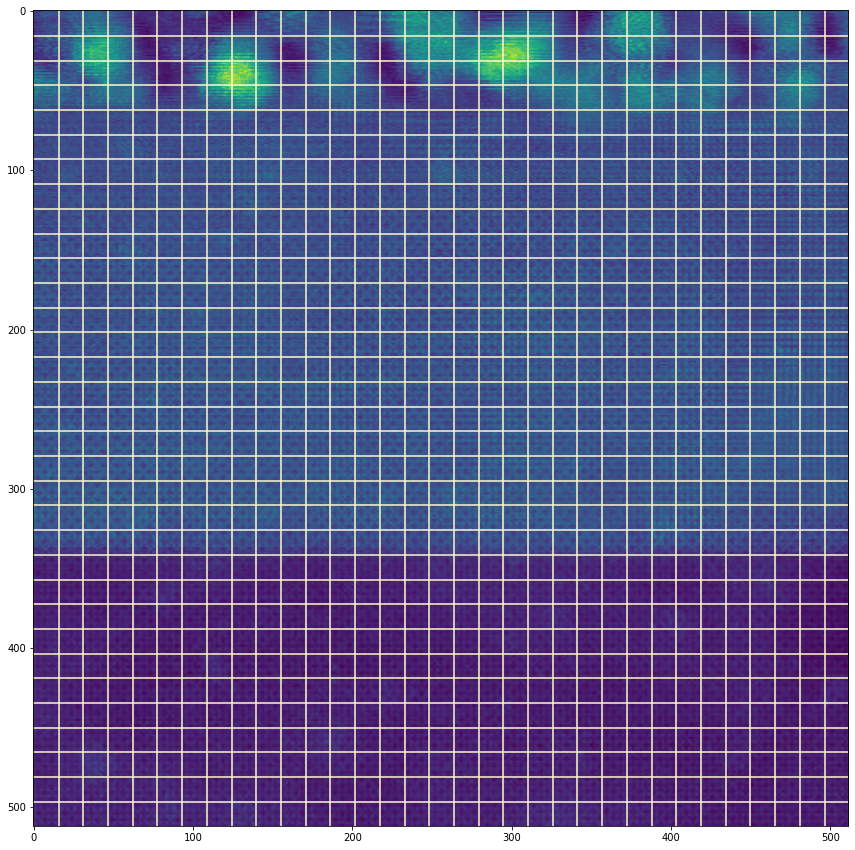

In [4]:
# Preview the chip size 
# Assumes image is square. If not, there may be distortions in this preview that will not appear in the final chipped image
img_path = os.path.join(data_path, img_name)

img = mpimg.imread(img_path)
width = img.shape[0]
chipsize = width/n_columns
x_grid_lst = np.linspace(chipsize, width-chipsize, n_columns-1)

plt.figure(figsize=(15, 15))
imgplot = plt.imshow(img)
for x_loc in x_grid_lst:
    plt.axvline(x=x_loc, c='lemonchiffon')
    plt.axhline(y=x_loc, c='lemonchiffon')

## Step 3: Initialize the classifier and create chips

This classifier gives you the option of saving a copy of the preprocessed image and/or the chips. If you'd rather not save things, don't pass in the savepath parameter. If you do want to save things, you'll need to provide the savepath as well as either a name or a file type (for preprocess or chips, respectively). An example of each scenario can be found here:

To save the preprocessed image:

```classifier.preprocess("CLAHE", savepath=results_path, img_name="preprocessed.jpg", clipLimit=2.0)```

To NOT save the preprocessed image:

```classifier.preprocess("CLAHE", clipLimit=2.0)```

To save the chips:

```classifier.chips_genesis(n_columns, savepath=chips_path, imgs_ext=".jpg")```

To NOT save the chips:

```classifier.chips_genesis(n_columns)```

In [5]:
classifier = PychipClassifier(data_path, img_name, spectrum_name)
#classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_columns)

## Step 4: Define your support set

You have two options for defining a support set:
- A filepath
- A dictionary

If you already have chips saved on your computer that you want to use as support sets, follow the instructions in the [Support set from filepath](#filepath) section

Otherwise, follow the instructions in the [creating a support set dictionary](#dictionary) section.


<a id="filepath"></a>
### Support set from filepath

Your file structure should look like this:
```
supports
└───set_1_label
│   │   R23C0.jpg
│   │   R21C21.jpg
│   │   R32C17.jpg
└───set_2_label
│   │   ...
└───set_3_label
│   │   ...
```

In [6]:
# update this if necessary
#support_folder = "Testing/feb_2022_test/support/"

#classifier.support_genesis(support_path=support_folder)

<a id="dictionary"></a>
### Creating a support set dictionary


Chip names have the format R#C# (row# column#)
<br>
for an image with 10 rows and 10 columns:
   - the top left chip is R0C0
   - the top right chip is R0C9
   - the bottom left chip is R9C0
   - the bottom right chip is R9C9
   
<br>

Run the next cell for a reference map of available chips in your image, then adjust the following ```support_dict``` as necessary. You will need one key for each support set. Each key maps to a list of representative chips using the above naming convention. The lists of chips can be any length (between 1-9 chips each is recommended)

In [ ]:
fig, axs = plt.subplots(nrows=n_columns, ncols=n_columns, figsize=(20, 20))

for row in range(n_columns):
    for column in range(n_columns):
        chip_name = f"R{row}C{column}"
        chip = classifier.chips[chip_name]
        axs[row, column].imshow(chip)
        #axs[row, column].axis('off')
        axs[row, column].set_yticklabels([])
        axs[row, column].set_yticks([])
        axs[row, column].set_xticklabels([])
        axs[row, column].set_xticks([])
        
        if row == 0:
            axs[row, column].set_title(f"C{column}")
        if column == 0:
            axs[row, column].set_ylabel(f"R{row}")
        
plt.show()

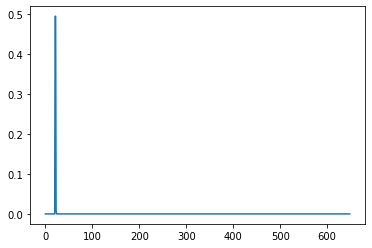

In [7]:
import matplotlib.pyplot as plt
plt.plot(classifier.chips_spectra['R30C14'])

In [8]:
support_dict = {#'Pt': ['R0C3', 'R0C12'],
                'Bright': ['R12C14', 'R9C27', 'R17C5'],
                'Dark': ['R26C4', 'R30C12', 'R26C22']}

While you're at it, update the set labels in the dictionary of colors below if necessary. You can also adjust their associated colors (which will appear in the resulting segmented image)

In [9]:
color_dict = {'Pt': (255, 0, 0),
              'Bright': (0, 255, 0),
              'Dark': (0, 0, 255),
              'no_label': (255, 255, 255)}

To confirm that your support sets look correct, run the following:

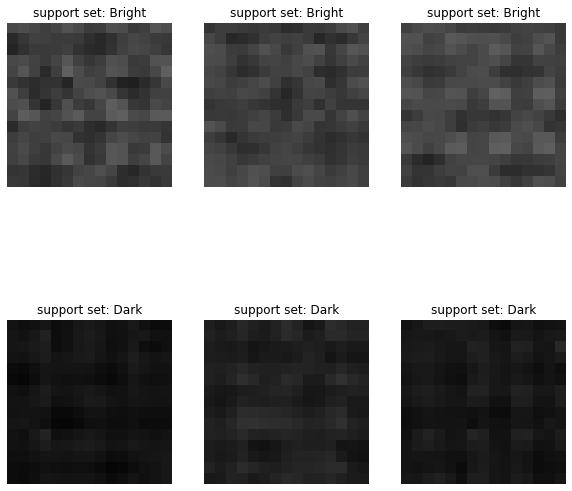

In [10]:
rows = len(support_dict.keys())
columns = max([len(support_dict[x]) for x in list(support_dict.keys())])

fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 10))

for row, sup_set in enumerate(support_dict.keys()):
    for col, chip_name in enumerate(support_dict[sup_set]):
        chip = classifier.chips[chip_name]
        axs[row, col].imshow(chip)
        axs[row, col].axis('off')
        axs[row, col].set_title(f"support set: {sup_set}")
plt.show()

Once your support set is satisfactory, run the following to pass it to the classifier:

In [11]:
classifier.support_genesis(support_dict=support_dict)

## Step 5: Run the few shot classifier

The preferred encoder is shufflenet (for speed and accuracy), but there are other options:
- resnet18
- resnet34
- resnet50
- resnet101
- resnet152
- torch101 (this is torch's resnet101)

In [12]:
classifier.predict(savepath=results_path, encoder='shufflenet', seed=75, filename='resultsfused1.csv')

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
18.347290754318237


## Step 6: Interpret results

The classifier has two properties that are most useful for interpreting the results:
- color_image (saves a segmented image with customized colors (according to the ```color_dict``` created above)
- results (returns a dataframe of predicted classes)

In [13]:
# this may take a while to execute
classifier.color_image(savepath=results_path, img_name='resultsfused1.jpg', color_dict=color_dict)

In [14]:
classifier.results.head(10)

,Bright,Dark,prediction,chip
R0C0,0.820510,0.179490,Bright,R0C0
R1C0,0.003420,0.996580,Dark,R1C0
R2C0,0.051710,0.948290,Dark,R2C0
R3C0,0.019579,0.980421,Dark,R3C0
R4C0,0.668038,0.331962,Bright,R4C0
R5C0,0.998456,0.001544,Bright,R5C0
R6C0,0.996690,0.003310,Bright,R6C0
R7C0,0.934866,0.065134,Bright,R7C0
R8C0,0.998483,0.001517,Bright,R8C0
R9C0,0.007456,0.992544,Dark,R9C0
